# Week 6 — Graph-RAG over Your Corpus
**Goal:** Build an entity graph from your corpus and retrieve evidence using neighborhood expansion.

**Colab tips:** You can run this notebook in Colab. If using your own PDFs, mount Drive.


In [ ]:

#@title Setup (Colab-friendly)
import os, re, json, math, time, random
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from typing import List, Dict, Tuple

DATA_DIR = "./data_week6"
os.makedirs(DATA_DIR, exist_ok=True)

corpus = pd.DataFrame({
    "doc_id": [f"doc{i}" for i in range(1,13)],
    "text": [
        "The Multi-Agent GenAI framework combines reinforcement learning agents with large language models to predict stock trends.",
        "Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.",
        "Agent Beta monitors market indicators such as moving averages, RSI, and trading volume for signal generation.",
        "Agent Gamma integrates signals from sentiment and technical indicators using a transformer-based fusion model.",
        "The ensemble of agents communicates through a coordination layer using weighted consensus for final stock price prediction.",
        "Historical data from NASDAQ and NYSE were used to train the agents on 5 years of daily prices.",
        "The proposed model outperforms LSTM and ARIMA baselines with an average RMSE reduction of 12%.",
        "Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.",
        "The sentiment-agent uses a fine-tuned FinBERT model for polarity detection on market-related tweets.",
        "Market-agent relies on quantitative features like SMA, EMA, RSI, and MACD for trend estimation.",
        "Experiments show that when sentiment signals are positive and technical momentum is bullish, the ensemble predicts upward movement with 87% accuracy.",
        "The ablation study demonstrates that removing the sentiment-agent decreases performance by 9% on F1 score."
    ]
})

corpus.to_csv(os.path.join(DATA_DIR, "corpus.csv"), index=False)
print("✅ Custom AI corpus created and saved as data_week6/corpus.csv")
corpus.head()


✅ Custom AI corpus created and saved as data_week6/corpus.csv


,doc_id,text
0,doc1,The Multi-Agent GenAI framework combines reinf...
1,doc2,Agent Alpha collects real-time financial news ...
2,doc3,Agent Beta monitors market indicators such as ...
3,doc4,Agent Gamma integrates signals from sentiment ...
4,doc5,The ensemble of agents communicates through a ...


## 1. Lightweight Entity Extraction

In [ ]:

ENTITY_PATTERNS = {
    # Agents / Models / Framework Components
    "AGENT": r"Agent\s+[A-Z][a-zA-Z]*|Multi[-\s]?Agent\s+GenAI|Sentiment[-\s]?Agent|Market[-\s]?Agent",

    # Models / Methods
    "MODEL": r"FinBERT|Transformer|LSTM|ARIMA|Ensemble|Fusion\s+Model",

    # Datasets or Markets
    "DATASET": r"NASDAQ|NYSE|S&P\s*500|financial\s+news|Twitter|Reddit",

    # Metrics
    "METRIC": r"RMSE|Accuracy|F1|AUC|Precision|Recall",

    # Signals / Indicators
    "SIGNAL": r"RSI|SMA|EMA|MACD|Momentum|Sentiment",

    # Organizations / Sources
    "ORG": r"OpenAI|Google|Stanford|Visual\s+Geometry\s+Group"
}

import re
def extract_entities(text: str):
    ents = []
    for typ, pat in ENTITY_PATTERNS.items():
        for m in re.finditer(pat, text):
            ents.append((m.group(0), typ, m.start(), m.end()))
    return ents

rows = []
for _, r in corpus.iterrows():
    ents = extract_entities(r["text"])
    for e, typ, s, t in ents:
        rows.append({"doc_id": r["doc_id"], "entity": e, "type": typ, "start": s, "end": t, "span": r["text"][max(0,s-40):min(len(r['text']),t+40)]})
ents_df = pd.DataFrame(rows)
ents_df.head(10)


,doc_id,entity,type,start,end,span
0,doc1,Multi-Agent GenAI,AGENT,4,21,The Multi-Agent GenAI framework combines reinf...
1,doc2,Agent Alpha,AGENT,0,11,Agent Alpha collects real-time financial news ...
2,doc2,FinBERT,MODEL,82,89,ews and computes sentiment scores using FinBERT.
3,doc2,financial news,DATASET,31,45,Agent Alpha collects real-time financial news ...
4,doc3,Agent Beta,AGENT,0,10,Agent Beta monitors market indicators such as ...
5,doc3,RSI,SIGNAL,63,66,"ket indicators such as moving averages, RSI, a..."
6,doc4,Agent Gamma,AGENT,0,11,Agent Gamma integrates signals from sentiment ...
7,doc6,NASDAQ,DATASET,21,27,Historical data from NASDAQ and NYSE were used...
8,doc6,NYSE,DATASET,32,36,Historical data from NASDAQ and NYSE were used...
9,doc7,LSTM,MODEL,31,35,The proposed model outperforms LSTM and ARIMA ...


## 2. Relation Extraction (Co-occurrence within sentence)

In [ ]:

def sentence_split(text):
    import re
    return re.split(r"(?<=[.!?])\s+", text)

# 🔹 Step 1: Define relation keywords (patterns)
RELATION_PATTERNS = {
    "uses": r"\buses\b|\butilizes\b|\bemploys\b",
    "collects_from": r"\bcollects\b|\bgathers\b|\bextracts\b",
    "trained_on": r"\btrained\b|\bevaluated\b|\btested\b",
    "outperforms": r"\boutperforms\b|\bbeats\b",
    "integrates": r"\bintegrates\b|\bfuses\b|\bcombines\b"
}

edges = []

# 🔹 Step 2: Loop through each document and sentence
for _, r in corpus.iterrows():
    for sent in sentence_split(r["text"]):
        ents = extract_entities(sent)
        if len(ents) < 2:
            continue

        # Try to detect a relation keyword in the sentence
        relation = "related_to"
        for rel_name, rel_pat in RELATION_PATTERNS.items():
            if re.search(rel_pat, sent, re.IGNORECASE):
                relation = rel_name
                break

        # Link every entity pair in that sentence
        for i in range(len(ents)):
            for j in range(i + 1, len(ents)):
                e1, t1, *_ = ents[i]
                e2, t2, *_ = ents[j]
                edges.append({
                    "doc_id": r["doc_id"],
                    "head": e1,
                    "type1": t1,
                    "tail": e2,
                    "type2": t2,
                    "relation": relation,
                    "sentence": sent
                })

edges_df = pd.DataFrame(edges)
edges_df.head(10)


,doc_id,head,type1,tail,type2,relation,sentence
0,doc2,Agent Alpha,AGENT,FinBERT,MODEL,collects_from,Agent Alpha collects real-time financial news ...
1,doc2,Agent Alpha,AGENT,financial news,DATASET,collects_from,Agent Alpha collects real-time financial news ...
2,doc2,FinBERT,MODEL,financial news,DATASET,collects_from,Agent Alpha collects real-time financial news ...
3,doc3,Agent Beta,AGENT,RSI,SIGNAL,related_to,Agent Beta monitors market indicators such as ...
4,doc6,NASDAQ,DATASET,NYSE,DATASET,related_to,Historical data from NASDAQ and NYSE were used...
5,doc7,LSTM,MODEL,ARIMA,MODEL,outperforms,The proposed model outperforms LSTM and ARIMA ...
6,doc7,LSTM,MODEL,RMSE,METRIC,outperforms,The proposed model outperforms LSTM and ARIMA ...
7,doc7,ARIMA,MODEL,RMSE,METRIC,outperforms,The proposed model outperforms LSTM and ARIMA ...
8,doc8,Twitter,DATASET,Reddit,DATASET,related_to,"Sentiment scores are derived from Twitter, Red..."
9,doc8,Twitter,DATASET,financial news,DATASET,related_to,"Sentiment scores are derived from Twitter, Red..."


## 3. Build Graph (NetworkX) and Attach Evidence

In [ ]:

G = nx.Graph()
for _, e in ents_df.iterrows():
    G.add_node(e["entity"], type=e["type"])

for _, ed in edges_df.iterrows():
    G.add_edge(ed["head"], ed["tail"], doc_id=ed["doc_id"], sentence=ed["sentence"], relation=ed.get("relation", "related_to"))

len(G.nodes()), len(G.edges())


(19, 20)

In [ ]:
print("Nodes:", list(G.nodes())[:10])
print("Edges:", list(G.edges(data=True))[:5])


Nodes: ['Multi-Agent GenAI', 'Agent Alpha', 'FinBERT', 'financial news', 'Agent Beta', 'RSI', 'Agent Gamma', 'NASDAQ', 'NYSE', 'LSTM']
Edges: [('Agent Alpha', 'FinBERT', {'doc_id': 'doc2', 'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.', 'relation': 'collects_from'}), ('Agent Alpha', 'financial news', {'doc_id': 'doc2', 'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.', 'relation': 'collects_from'}), ('FinBERT', 'financial news', {'doc_id': 'doc2', 'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.', 'relation': 'collects_from'}), ('financial news', 'Twitter', {'doc_id': 'doc8', 'sentence': 'Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.', 'relation': 'related_to'}), ('financial news', 'Reddit', {'doc_id': 'doc8', 'sentence': 'Sentiment scores are derived from T

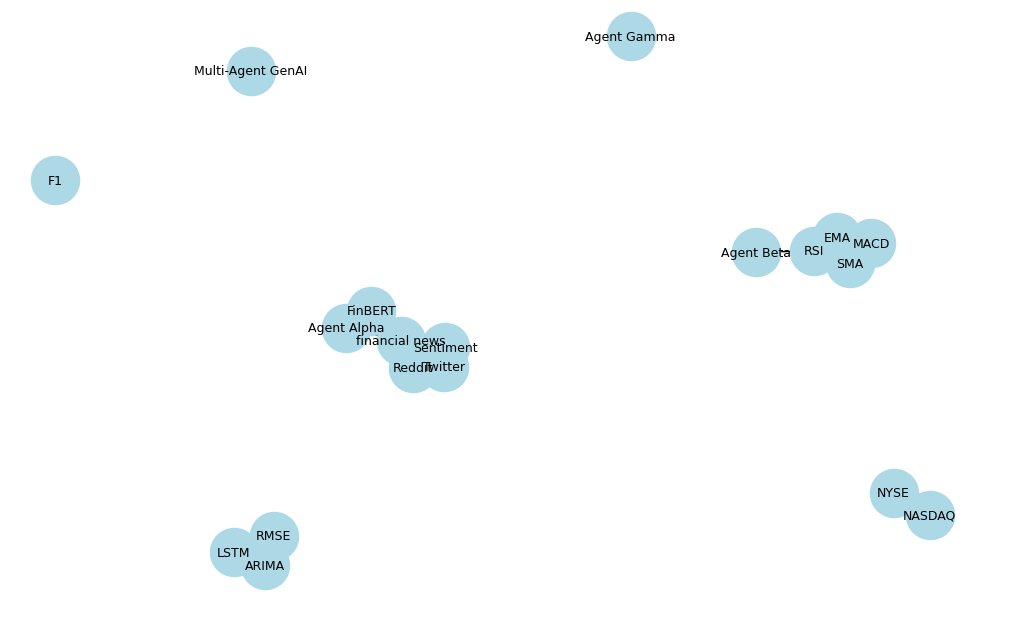

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_size=1200, node_color="lightblue", font_size=9)
plt.show()


In [ ]:
import pickle

with open("./data_week6/graph_stock_forecast.gpickle", "wb") as f:
    pickle.dump(G, f)

## 4. Graph-aware Retrieval

In [ ]:

def detect_seed_entities(query: str):
    seeds = []
    query_lower = query.lower()

    # Match by entity names
    for node in G.nodes():
        if any(word in query_lower for word in node.lower().split()):
            seeds.append(node)

    # Match by entity types mentioned in the query
    for node, data in G.nodes(data=True):
        node_type = data.get("type", "").lower()
        if node_type in query_lower:
            seeds.append(node)

    return list(dict.fromkeys(seeds))

def neighborhood_evidence(seeds, hops=1, max_spans=12):
    spans = []
    seen_edges = set()
    for s in seeds:
        nodes = nx.single_source_shortest_path_length(G, s, cutoff=hops).keys()
        for u in nodes:
            for v in G.neighbors(u):
                e = tuple(sorted([u, v]))
                if e in seen_edges:
                    continue
                seen_edges.add(e)
                data = G.get_edge_data(u, v)
                spans.append({
                    "u": u, "v": v,
                    "doc_id": data.get("doc_id"),
                    "sentence": data.get("sentence"),
                    "relation": data.get("relation", "related_to")
                })
                if len(spans) >= max_spans:
                    return spans
    return spans

def graph_rag(query: str, hops=1):
    seeds = detect_seed_entities(query)
    spans = neighborhood_evidence(seeds, hops=hops)
    return {"seeds": seeds, "spans": spans}


demo_out = graph_rag("Which model does Agent Alpha use for sentiment analysis?")
demo_out


{'seeds': ['Agent Alpha',
  'Agent Beta',
  'Agent Gamma',
  'Sentiment',
  'Multi-Agent GenAI',
  'FinBERT',
  'LSTM',
  'ARIMA'],
 'spans': [{'u': 'Agent Alpha',
   'v': 'FinBERT',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'Agent Alpha',
   'v': 'financial news',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'FinBERT',
   'v': 'financial news',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'financial news',
   'v': 'Twitter',
   'doc_id': 'doc8',
   'sentence': 'Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.',
   'relation': 'related_to'},
  {'u': 'f

In [ ]:
graph_rag("Which datasets were used to train the agents?")


{'seeds': ['Agent Alpha',
  'Agent Beta',
  'Agent Gamma',
  'Multi-Agent GenAI',
  'financial news',
  'NASDAQ',
  'NYSE',
  'Twitter',
  'Reddit'],
 'spans': [{'u': 'Agent Alpha',
   'v': 'FinBERT',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'Agent Alpha',
   'v': 'financial news',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'FinBERT',
   'v': 'financial news',
   'doc_id': 'doc2',
   'sentence': 'Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.',
   'relation': 'collects_from'},
  {'u': 'financial news',
   'v': 'Twitter',
   'doc_id': 'doc8',
   'sentence': 'Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.',
   'relation': 'relate

## 5. Prompt Assembly (stub)

In [ ]:

def assemble_prompt(query, seeds, spans):
    ev_lines = [f"- ({s['doc_id']}) {s['sentence']}" for s in spans]
    return f"""System: Answer using ONLY the evidence and cite (doc_id).
Query: {query}

Seeds: {', '.join(seeds)}

Evidence:
""" + "\n".join(ev_lines) + "\n\nAnswer:"

print("\nPrompt Preview:\n")
print(assemble_prompt("Which model does Agent Alpha use for sentiment analysis?",
                      demo_out["seeds"], demo_out["spans"]))



Prompt Preview:

System: Answer using ONLY the evidence and cite (doc_id).
Query: Which model does Agent Alpha use for sentiment analysis?

Seeds: Agent Alpha, Agent Beta, Agent Gamma, Sentiment, Multi-Agent GenAI, FinBERT, LSTM, ARIMA

Evidence:
- (doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.
- (doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.
- (doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.
- (doc8) Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.
- (doc8) Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.
- (doc8) Sentiment scores are derived from Twitter, Reddit, and financial news articles collected via API integration.
- (doc3) Agent Beta monitors market indicators such as moving averages, RSI, and trading volume

## 6. Optional: Graph Visualization

/tmp/ipython-input-333128317.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.title("Entity Graph (demo)"); plt.tight_layout(); plt.show()


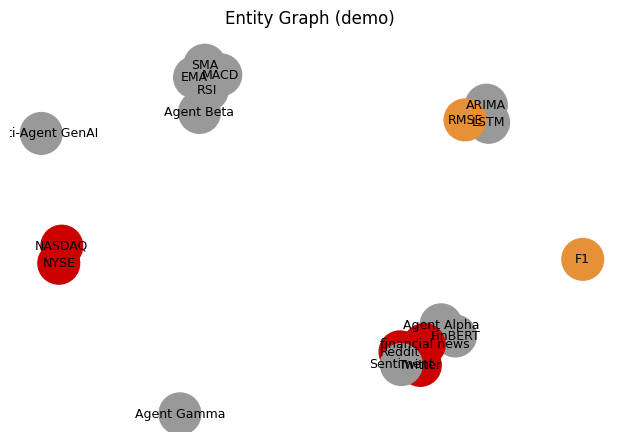

In [ ]:

import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=7)
type_to_color = {"METHOD":"#6aa84f","AUTHOR":"#3c78d8","DATASET":"#cc0000","PAPER":"#674ea7","METRIC":"#e69138"}
node_colors = [type_to_color.get(G.nodes[n].get("type",""), "#999") for n in G.nodes()]
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=900, font_size=9, edge_color="#bbb")
plt.title("Entity Graph (demo)"); plt.tight_layout(); plt.show()


#Ablation – Compare Dense vs Graph-RAG Retrieval

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load baseline embedding model ---
embedder = SentenceTransformer("all-MiniLM-L6-v2")
sentences = corpus["text"].tolist()
sentence_embeddings = embedder.encode(sentences, convert_to_tensor=True)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def dense_retrieve(query, top_k=3):
    """Baseline dense retriever using cosine similarity."""
    q_emb = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(q_emb, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    results = []
    for score, idx in zip(top_results[0], top_results[1]):
        results.append({
            "doc_id": corpus.iloc[idx.item()]["doc_id"], # Convert tensor index to integer
            "sentence": corpus.iloc[idx.item()]["text"], # Convert tensor index to integer
            "score": float(score)
        })
    return results

In [ ]:
# --- 2. Graph-RAG retrieval wrapper ---
def graph_retrieve(query, hops=1):
    result = graph_rag(query, hops=hops)
    return result["spans"]


In [ ]:
# --- 3. Test queries ---
queries = [
    "Which model does Agent Alpha use for sentiment analysis?",
    "Which datasets were used to train the agents?",
    "Which model outperforms LSTM?",
    "Which agent integrates sentiment and market indicators?",
    "What happens when the sentiment-agent is removed?"
]



In [ ]:
1# --- 4. Run comparison and log correctness manually ---
results = []

for q in queries:
    print(f"\n🔹 Query: {q}")

    # Dense retrieval
    dense_results = dense_retrieve(q, top_k=2)
    print("\n-- Dense Retrieval --")
    for r in dense_results:
        print(f"({r['doc_id']}) {r['sentence']}\n")

    # Graph-RAG retrieval
    graph_results = graph_retrieve(q, hops=1)
    print("-- Graph-RAG Retrieval --")
    for s in graph_results[:2]:
        print(f"({s['doc_id']}) {s['sentence']}\n")
    # --------------------------------------------------
    # ✅ Manually mark correctness after inspecting
    # --------------------------------------------------
    dense_correct = int(input(f"Was DENSE retrieval correct for '{q}'? (1=yes, 0=no): "))
    graph_correct = int(input(f"Was GRAPH-RAG retrieval correct for '{q}'? (1=yes, 0=no): "))

    results.append({"query": q, "retriever": "Dense", "correct": dense_correct})
    results.append({"query": q, "retriever": "Graph-RAG", "correct": graph_correct})




🔹 Query: Which model does Agent Alpha use for sentiment analysis?

-- Dense Retrieval --
(doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.

(doc9) The sentiment-agent uses a fine-tuned FinBERT model for polarity detection on market-related tweets.

-- Graph-RAG Retrieval --
(doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.

(doc2) Agent Alpha collects real-time financial news and computes sentiment scores using FinBERT.

Was DENSE retrieval correct for 'Which model does Agent Alpha use for sentiment analysis?'? (1=yes, 0=no): 1
Was GRAPH-RAG retrieval correct for 'Which model does Agent Alpha use for sentiment analysis?'? (1=yes, 0=no): 1

🔹 Query: Which datasets were used to train the agents?

-- Dense Retrieval --
(doc6) Historical data from NASDAQ and NYSE were used to train the agents on 5 years of daily prices.

(doc10) Market-agent relies on quantitative features like SMA, EMA, RSI, a

In [ ]:
# --- 5. Save ablation results ---
ablation_df = pd.DataFrame(results)
ablation_path = "./data_week6/ablation_results_graph.csv"
ablation_df.to_csv(ablation_path, index=False)
print(f"\n✅ Ablation results saved to {ablation_path}")
display(ablation_df)



✅ Ablation results saved to ./data_week6/ablation_results_graph.csv


,query,retriever,correct
0,Which model does Agent Alpha use for sentiment...,Dense,1
1,Which model does Agent Alpha use for sentiment...,Graph-RAG,1
2,Which datasets were used to train the agents?,Dense,1
3,Which datasets were used to train the agents?,Graph-RAG,0
4,Which model outperforms LSTM?,Dense,1
5,Which model outperforms LSTM?,Graph-RAG,1
6,Which agent integrates sentiment and market in...,Dense,1
7,Which agent integrates sentiment and market in...,Graph-RAG,0
8,What happens when the sentiment-agent is removed?,Dense,1
9,What happens when the sentiment-agent is removed?,Graph-RAG,0


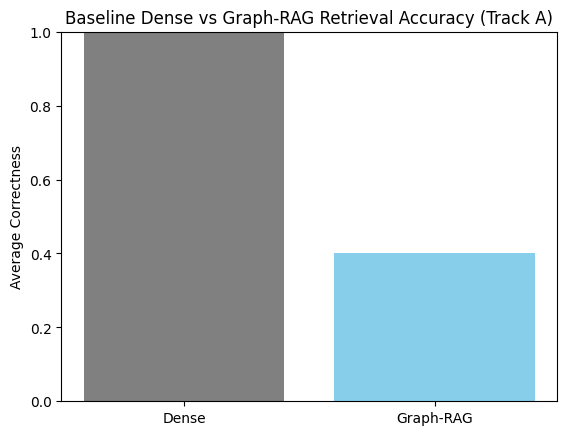

In [ ]:
# --- 6. Optional quick visualization ---
acc = ablation_df.groupby("retriever")["correct"].mean().reset_index()
plt.bar(acc["retriever"], acc["correct"], color=["gray", "skyblue"])
plt.ylabel("Average Correctness")
plt.title("Baseline Dense vs Graph-RAG Retrieval Accuracy (Track A)")
plt.ylim(0, 1)
plt.show()